# Construct a figure showing sensitivity analysis results:

example notebook to create a figure to show sensitivity analysis results by Beo

In [1]:
import itertools
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.default'] = 'regular'

In [3]:
# name of the file containing the data in .csv format
data_file = 'data/model_params_and_results_sensitivity_final_merged.csv'

Define the columns that contain the input parameters and model results:

In [4]:
# name of the index column:
index_column = 'index'

# index row for the base case model
base_case_model = 0

# list the parameters that you want to include
sensitivity_params = ['fault_widths', 'fault_fluxes', 'exhumation_rate', 
                      'thermal_gradient', 'ra', 'durations_yr']

# list the first and last index row for each parameter
#param_rows = [[1, 3], [4, 6]]

# show the percentage change or the ratio of each parameter comapred to the base case:
x_axis_scale = 'fraction'

# what to plot on the y axis
result_params = ['width_partial_reset', 'width_full_reset']

# base case runtime: 
default_runtime = 2e5

Some parameters that control how the figure looks:

In [5]:
# markers for the different parameters
markers = ['o', 's', 'v', '^', 'd', 'h']
base_case_marker = '*'
marker_size = 50
base_case_marker_size = 150

# labels for the legend
labels = ['Width fault zone (m)', r'Flux (m$^2$a$^{-1}$)', r'Exhumation rate ($m\;yr^{-1}$)', 
          r'Thermal gradient ($\degree C\;m^{-1}$)', 'Aerodynamic resistance ($s\;m^{-1}$)', 'Duration (yr)']

# label on x and y-axis
xlabel = 'Parameter value / base value'
ylabels = ['Width partial reset (m)', 'Width full reset (m)']

# limits of the x and y-axis
xlims = [[0, 3.0], [0, 11.0]]
ylims = [[0, 250], [0, 3600]]

# colors for the different parameters
# use standard colors like this:
#colors = ['blue', 'orange']
# or check here for nicer RGB color schemes: http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
colors = [[102/255., 194/255., 165/255.], [252/255., 141/255., 98/255.], [141/255., 160/255., 203/255.], 
          [231/255., 138/255., 195/255.], [166/255., 216/255., 84/255.], [255/255., 217/255., 47/255.]]

legend_location = 'lower right'
legend_font_size = 'small'
legend_ncol = 3

# figure size (in inches):
figsize = (6, 5)

Read the data file:

In [6]:
# read the datafile using pandas:
# cols to read in dataframe:
#cols = ['runtime_yr', 'fault_widths', 'fault_fluxes', 'exhumation_rate', 'thermal_gradient', 'ra', 'durations', 
#        'x_min_partial_reset_surface', 'x_max_partial_reset_surface', 'x_min_full_reset_surface', 'x_max_full_reset_surface']

#cols = ['runtime_yr', 'fault_widths', 'fault_fluxes', 'exhumation_rate', 'thermal_gradient', 'ra', 'durations',#, 
#       'x_min_partial_reset_surface']#, 'x_max_partial_reset_surface', 'x_min_full_reset_surface', 'x_max_full_reset_surface']


df = pd.read_csv(data_file)
#df = df.set_index(index_column)
#df

calculate the width of the partial and full reset zones:

In [7]:
df['width_partial_reset'] = df['x_max_partial_reset_surface'] - df['x_min_partial_reset_surface']
df['width_full_reset'] = df['x_max_full_reset_surface'] - df['x_min_full_reset_surface']

df.loc[df['width_partial_reset'].isnull(), 'width_partial_reset'] = 0
df.loc[df['width_full_reset'].isnull(), 'width_full_reset'] = 0

convert fluid flux column to array

In [8]:
list_cols = ['fault_fluxes', 'durations', 'fault_widths']

for lcol in list_cols:
    fl = df[lcol].values.tolist()
    fla = np.array([float(str(f).strip('[').strip(']')) for f in fl])
    df[lcol] = fla

df['durations_yr'] = df['durations'] / (365.25*24*3600)

find out in which rows each particular parameter varies

In [9]:
param_values = []
result_values = []

for param in sensitivity_params:
    if param == 'durations_yr':
        dfr = df.loc[df['durations_yr'] != default_runtime]
        param_values.append(dfr['runtime_yr'])
        
        r = []
        for result_param in result_params:
            ri = dfr[result_param]
            r.append(ri)
        result_values.append(r)
        
    else:
        dfb = df.loc[df['runtime_yr'] == default_runtime]
        base_ind = dfb.index[0]
        ind = dfb[param] != dfb.loc[base_ind, param]
        
        p = dfb.loc[ind, param]
        param_values.append(p)
        r = []
        for result_param in result_params:
            ri = dfb.loc[ind, result_param]
            r.append(ri)
        result_values.append(r)  

find the base case params, this is assumed to be the first model run in the .csv file:

In [10]:
base_params = []
base_results = []
for param in sensitivity_params:
    dfb = df.loc[df['runtime_yr'] == default_runtime]
    base_ind = dfb.index[0]
    base_params.append(dfb.loc[base_ind, param])
    r = []

for result_param in result_params:
    ri = dfb.loc[base_ind, result_param]
    #r.append(ri)
    base_results.append(ri)
    
print('base case: ', base_params, base_results)

base case:  [20.0, -1.2041473369331001e-05, 0.0001, 0.04, 80, 200000.0] [84.0, 33.0]


show the parameters and model results:

In [11]:
for param, param_val, result_var in zip(sensitivity_params, param_values, result_values):
    print('-------')
    print(param)
    print (param_val, result_var)

-------
fault_widths
98     10.0
120    30.0
131    40.0
Name: fault_widths, dtype: float64 [98     74.0
120    91.0
131    98.0
Name: width_partial_reset, dtype: float64, 98     24.0
120    41.0
131    50.0
Name: width_full_reset, dtype: float64]
-------
fault_fluxes
32   -0.000019
43   -0.000016
54   -0.000013
65   -0.000010
76   -0.000006
87   -0.000003
Name: fault_fluxes, dtype: float64 [32    88.0
43    87.0
54    84.0
65    82.0
76    72.0
87    27.0
Name: width_partial_reset, dtype: float64, 32    36.0
43    34.0
54    33.0
65    32.0
76    27.0
87     0.0
Name: width_full_reset, dtype: float64]
-------
exhumation_rate
263    0.000010
274    0.000025
285    0.000050
296    0.000075
307    0.000250
318    0.000500
329    0.000750
340    0.001000
Name: exhumation_rate, dtype: float64 [263      19.0
274      28.0
285      45.0
296      58.0
307     383.0
318    1463.0
329    2501.0
340    3426.0
Name: width_partial_reset, dtype: float64, 263      10.0
274      14.0
285      20.0
29

make the figure

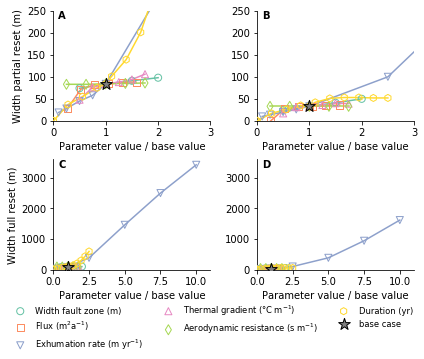

In [12]:
fig, panels = pl.subplots(2, 2, figsize=figsize)

panelsr = panels.ravel()

for j, xlim, ylim in zip(itertools.count(), xlims, ylims):
    for i, panel in enumerate(panels[j]):
        for param, param_value, base_param, result_value, color, marker, label in zip(sensitivity_params, param_values, base_params, result_values, colors, markers, labels):

            if i > 0 or j > 0:
                label = ''

            if x_axis_scale is 'fraction':
                x_values = param_value.values / base_param
                x_values = np.append(x_values, [1.0])
            
            y_values = result_value[i].values
            
            # add base case values:
            y_values = np.append(y_values, [base_results[i]])
            
            # make sure values are sorted
            s = np.argsort(x_values)
            
            panel.plot(x_values[s], y_values[s], color=color, label='', zorder=100)
            panel.scatter(x_values, y_values, color='None', edgecolor=color, marker=marker, s=marker_size, label=label, zorder=101)

        # show the base case value:
        if i == 0  and j == 0:
            blabel = 'base case'
        else:
            blabel = ''
        panel.scatter([1.0], [base_results[i]],
                      color='gray', edgecolor='black', marker=base_case_marker,
                      s=base_case_marker_size, label=blabel, zorder=102)

    for panel, ylabel in zip(panels[j], ylabels):
        #panel.set_ylabel(ylabel)
        panel.set_xlim(xlim)
        panel.set_ylim(ylim)

for panel, ylabel in zip(panels, ylabels):
    panel[0].set_ylabel(ylabel)


for panel in panelsr:
    panel.set_xlabel(xlabel)
    
# make the figure look nicer:
for i, panel in enumerate(panelsr):
    panel.grid(False)
    panel.spines['top'].set_visible(False)
    panel.spines['right'].set_visible(False)
    panel.text(0.03, 1.0, string.ascii_uppercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='top', fontsize='medium')

# add a legend
fig.tight_layout()
fig.subplots_adjust(bottom=0.24)
fig.legend(loc='lower center', fontsize=legend_font_size, ncol=legend_ncol, frameon=False)

and save the figure:

In [13]:
# svae the figure as pdf and png file
fn = data_file[:-4] + '_sensitivity_fig.pdf'
print('done, saving figure as %s' % fn)
fig.savefig(fn)

# svae the figure as pdf and png file
fn = data_file[:-4] + '_sensitivity_fig.png'
print('done, saving figure as %s' % fn)
fig.savefig(fn, dpi=250)

done, saving figure as data/model_params_and_results_sensitivity_final_merged_sensitivity_fig.pdf
done, saving figure as data/model_params_and_results_sensitivity_final_merged_sensitivity_fig.png
